In [1]:
#make sure your drive path is correct! 
# macOS/OS X
# drive_path = '/Volumes/Brain2017/data/dynamic-brain-workshop/brain_observatory_cache/'

# Windows (a good guess)
# drive_path = 'e:/data/dynamic-brain-workshop/brain_observatory_cache'

# Linux (will vary; the following is possibly what Ubuntu will do)
# drive_path = '/media/Brain2017/data/dynamic-brain-workshop/brain_observatory_cache'

# AWS
drive_path = '/data/dynamic-brain-workshop/brain_observatory_cache/'

In [2]:
# We need to import these modules to get started
import numpy as np
import pandas as pd
import os
import sys
import h5py
import seaborn as sns 
from scipy.ndimage.measurements import center_of_mass

import matplotlib.pyplot as plt
%matplotlib inline

In [167]:
from master_analysis import *

/data/dynamic-brain-workshop/brain_observatory_cache/brain_observatory_manifest.json


In [3]:

from allensdk.core.brain_observatory_cache import BrainObservatoryCache

manifest_file = os.path.join(drive_path,'brain_observatory_manifest.json')
print manifest_file

boc = BrainObservatoryCache(manifest_file=manifest_file)

/data/dynamic-brain-workshop/brain_observatory_cache/brain_observatory_manifest.json


In [4]:
def vectorize(mat):
    """Takes a square symmetric matrix mat and returns the vectorized form. Like matlab's squareform.

         Note: could probably also just use scipy's squareform function."""
    assert mat.shape[0] == mat.shape[1]

    vec = mat[:, 0]
    for row in range(1, mat.shape[1]):
        vec = np.concatenate((vec, mat[row:, row]))

    return vec

In [17]:
from scipy.stats import kendalltau as kt
import numpy as np
import scipy.spatial.distance
def get_kt(rsm1,rsm2):
    '''Gets Kendall tau-a measurements between two RDM matrices, first vectorizes matrices
    and then computes kt using scipy kendall-tau function'''
    np.fill_diagonal(rsm1,0)
    np.fill_diagonal(rsm2,0)
    vec_rsm1 = vectorize(rsm1)
    #
    vec_rsm2 = vectorize(rsm2)

    #vec_rsm1 = scipy.spatial.distance.squareform(rsm1)
    #vec_rsm2 = scipy.spatial.distance.squareform(rsm2)
    k = kt(vec_rsm1, vec_rsm2).correlation
    return k

In [5]:
exps=pd.read_hdf(r'/home/arib/SWDB_2017/swdb_2017_tools/projects/mouseRSA/exps_w_RSA.h5',mode='r')


In [6]:
exps = pd.read_hdf(r'/home/nataliam/swdb_2017_tools/projects/mouseRSA/exps_w_RSA_wrunning.h5',mode='r')

In [413]:
exps.loc[(exps.imaging_depth>100) & (exps.imaging_depth<=200),'imaging_depth']=175
exps.loc[(exps.imaging_depth>300) & (exps.imaging_depth<500),'imaging_depth']=350
exps.loc[(exps.imaging_depth>200) & (exps.imaging_depth<=300),'imaging_depth']=275
exps.loc[(exps.cre_line=='Nr5a1-Cre'),'imaging_depth']=275

In [288]:
boc.get_all_cre_lines()

[u'Cux2-CreERT2',
 u'Emx1-IRES-Cre',
 u'Nr5a1-Cre',
 u'Rbp4-Cre_KL100',
 u'Rorb-IRES2-Cre',
 u'Scnn1a-Tg3-Cre']

In [345]:
layers=[]
for i,exp in exps.iterrows():
    if (exp.imaging_depth==175) & (exp.cre_line=='Cux2-CreERT2'):
        layers.append('layer_2/3')
    elif (exp.imaging_depth==175) & (exp.cre_line=='Emx1-IRES-Cre'):
        layers.append('layer_2/3')
    elif (exp.imaging_depth==275) & (exp.cre_line=='Emx1-IRES-Cre'):
        layers.append('layer_4')
    elif (exp.imaging_depth==275) & (exp.cre_line=='Cux2-CreERT2'):
        layers.append('layer_4')
    elif exp.cre_line=='Nr5a1-Cre':
        layers.append('layer_4')
    elif (exp.imaging_depth==350) & (exp.cre_line=='Emx1-IRES-Cre'):
        layers.append('layer_5')
    elif exp.cre_line=='Rorb-IRES2-Cre':
        layers.append('layer_4')
    elif exp.cre_line=='Rbp4-Cre_KL100':
        layers.append('layer_5')
    elif exp.cre_line=='Scnn1a-Tg3-Cre':
        layers.append('layer_4')


In [346]:
len(layers)

199

In [8]:
def get_population_rf(boc, experiment_id):
    c_flag = 'C'
    lsn_name = 'locally_sparse_noise'
    rf_name = 'receptive_field_lsn'
    #
    for a in boc.get_ophys_experiments(experiment_container_ids=[experiment_id]):
        if a['session_type'].endswith('2'):
            c_flag = 'C2'
            if a['targeted_structure'] != 'VISp':
                lsn_name = 'locally_sparse_noise_8deg'
                rf_name = 'receptive_field_lsn8'
            else:
                lsn_name = 'locally_sparse_noise_4deg'
                rf_name = 'receptive_field_lsn4'

    drive_path = boc.manifest.get_path('BASEDIR')
    if c_flag=='C':
        session_id = boc.get_ophys_experiments(experiment_container_ids=[experiment_id], stimuli=[lsn_name])[0]['id']
        analysis_file = os.path.join(drive_path, 'ophys_experiment_analysis', str(session_id)+'_three_session_C_analysis.h5')
    elif c_flag=='C2':    
        session_id = boc.get_ophys_experiments(experiment_container_ids=[experiment_id], stimuli=[lsn_name])[0]['id']
        analysis_file = os.path.join(drive_path, 'ophys_experiment_analysis', str(session_id)+'_three_session_C2_analysis.h5')

    
    f = h5py.File(analysis_file, 'r')
    receptive_field = f['analysis'][rf_name].value
    f.close()
    pop_rf = np.nansum(receptive_field, axis=(2,3))
    return pop_rf

In [9]:
def get_population_rf(boc, experiment_id):
    c_flag = 'C'
    lsn_name = 'locally_sparse_noise'
    rf_name = 'receptive_field_lsn'
    #
    for a in boc.get_ophys_experiments(experiment_container_ids=[experiment_id]):
        if a['session_type'].endswith('2'):
            c_flag = 'C2'
            if a['targeted_structure'] != 'VISp':
                lsn_name = 'locally_sparse_noise_8deg'
                rf_name = 'receptive_field_lsn8'
            else:
                lsn_name = 'locally_sparse_noise_4deg'
                rf_name = 'receptive_field_lsn4'

    drive_path = boc.manifest.get_path('BASEDIR')
    if c_flag=='C':
        session_id = boc.get_ophys_experiments(experiment_container_ids=[experiment_id], stimuli=[lsn_name])[0]['id']
        analysis_file = os.path.join(drive_path, 'ophys_experiment_analysis', str(session_id)+'_three_session_C_analysis.h5')
    elif c_flag=='C2':    
        session_id = boc.get_ophys_experiments(experiment_container_ids=[experiment_id], stimuli=[lsn_name])[0]['id']
        analysis_file = os.path.join(drive_path, 'ophys_experiment_analysis', str(session_id)+'_three_session_C2_analysis.h5')

    
    f = h5py.File(analysis_file, 'r')
    receptive_field = f['analysis'][rf_name].value
    f.close()
    pop_rf = np.nansum(receptive_field, axis=(2,3))
    return pop_rf


def get_rf_coms(exps):
    coms = []
    for exp_id in exps.id.values:
        try:
            rf = get_population_rf(boc, exp_id)
            if rf.shape== (8,14):
                # 8 deg sparse noise
                com = np.array(center_of_mass(rf))*9.3 # to degrees
            else:
                com = np.array(center_of_mass(rf))*4.6 # to degrees

        except:
            com = (np.nan, np.nan)
        coms.append(com)
    return coms


In [198]:
def scatter_viz(to_plot,exps_grouped):
    
    plt.subplots_adjust(bottom = 0.1)
    plt.subplots_adjust(bottom = 0.1)

    areas = exps_grouped.targeted_structure
    
    for area in areas.unique():

        plt.scatter(
            to_plot[areas.values==area, 0], to_plot[areas.values==area, 1], marker = 'o'
            )

    plt.legend(areas.unique())

In [ ]:
com2=np.array

In [560]:
clusters=pd.read_hdf('final_cluster_bools.h5')
coms=pd.read_hdf('RF_COMs.h5')

In [565]:
clusters.head()

,0,1,2,3,4,5,6,7,8,9,...,189,190,191,192,193,194,195,196,197,198
0,False,False,True,True,True,True,True,True,True,True,...,True,True,True,False,False,True,True,False,True,True
1,True,True,False,True,True,False,False,True,False,True,...,True,True,True,True,False,True,False,False,False,False
2,True,True,False,True,True,False,False,True,False,True,...,False,True,False,True,True,True,False,False,False,False


In [563]:
#coms = get_rf_coms(exps)
cluster1=clusters.iloc[0]
cluster2=clusters.iloc[1]
cluster3=clusters.iloc[2]

In [ ]:
coms.iloc[0]

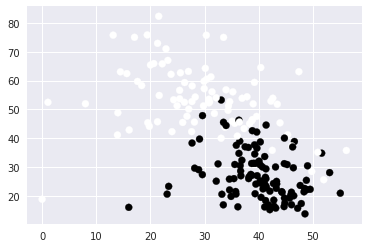

In [564]:
plt.scatter(coms[0],coms[1],c=cluster1)

In [103]:
def remove_nan_rsms(exps_grouped):
    nan_indexes = []
    for i,r in exps_grouped.iterrows():
        rsm = r.rsm.values

        this_nan_indexes = np.argwhere(np.sum(np.isnan(rsm),axis=1)> rsm.shape[0]/2 ).flatten()
        nan_indexes += list(this_nan_indexes)

    nan_indexes = np.unique(nan_indexes)

    # now remove them
    for i,r in exps_grouped.iterrows():
        exps_grouped['rsm'][i] = r.rsm.drop(r.rsm.index[nan_indexes], axis = 0).drop(r.rsm.index[nan_indexes], axis = 1)


    return exps_grouped

In [425]:
def get_experiments_grouped(exps,targeted_structures,cre_lines,imaging_depths, stim_type='all',
                            rsm_name = 'rsa_mean_mean_mahala', cluster = None,
                            donor_name=None,rsm_selection='mean'):
    ''' Gets Kendall tau measurement for all matrices for a certain list of
    visual areas, cre lines, and imaging depths
    If multiple RSAs exist for one mouse, average them together
    If multiple RSAs for one targeted structure, cre line, or imaging depth 
    
    For now, takes a list of ei'''
    if cluster is not None:
        exps = exps.iloc[cluster,:]
        
        
    #  remove rows if the rsa == 0
    # note we have to do this stinky thing because just testing ==0 won't work for the RSA arrays
    exps = exps[ 
        ~exps[rsm_name].apply(
            lambda x: isinstance(x,int)).values]
    


    # first get 'maximal subset' of valid indexes: those strings present in all valid index lists
    maximal_subset = list(pd.Series(np.hstack(exps.valid_stim)).unique())
    for cre_line in cre_lines:
        
        available_imaging_depths=exps[exps.cre_line==cre_line].imaging_depth.unique()
        for imaging_depth in imaging_depths:
            if imaging_depth in available_imaging_depths:
                for targeted_structure in targeted_structures:
                    available_targeted_structures=exps[(exps.cre_line==cre_line) & 
                                                       (exps.imaging_depth==imaging_depth)].targeted_structure.unique()
                    if targeted_structure in available_targeted_structures:
                        exp_group = exps.groupby(['cre_line','imaging_depth','targeted_structure']).get_group(
                                (cre_line,imaging_depth,targeted_structure))


                        # loop to create subset list
                        for i in range(len(exp_group)):
                            for s in maximal_subset:
                                if s not in exp_group['valid_stim'].iloc[i]:

                                    maximal_subset.remove(s)

                                    continue
                else:
                    continue
                    
    print len(maximal_subset)     
    
    
    # now allow for just some stimuli types
        
    if stim_type=='static_gratings':
        for s in maximal_subset:
            if '(' not in i:
                maximal_subset.remove(s)
        #drop all else from 'valid_stim'
    elif stim_type=='natural_movie':
        for s in maximal_subset:
            if 'nm' not in i:
                maximal_subset.remove(s)
    elif stim_type=='natural_movie':
        for s in maximal_subset:
            if isinstance(s,str):
                maximal_subset.remove(s)            
        
    print imaging_depths
    exps_grouped=pd.DataFrame(columns=['cre_line','imaging_depth','targeted_structure','rsm'])
    for cre_line in cre_lines:
        available_imaging_depths=exps[exps.cre_line==cre_line].imaging_depth.unique()
        for imaging_depth in imaging_depths:
            if imaging_depth in available_imaging_depths:
            
            
                print imaging_depth
                for targeted_structure in targeted_structures:
                    available_targeted_structures=exps[(exps.cre_line==cre_line) & 
                                                       (exps.imaging_depth==imaging_depth)].targeted_structure.unique()
                    if targeted_structure in available_targeted_structures:

                        exp_group = exps.groupby(['cre_line','imaging_depth','targeted_structure']).get_group(
                                (cre_line,imaging_depth,targeted_structure))

                        rsms=exp_group[rsm_name]


                        if rsm_selection=='mean':


                            rsms = rsms.apply(lambda x: x.loc[maximal_subset, maximal_subset].values)
                            #rsms = rsms.apply(lambda x: x.values)
                            rsm=rsms.mean()
                            rsm=pd.DataFrame(data=rsm,index=maximal_subset,columns=maximal_subset)

                            #rsm = rsms.mean()

                            to_add=pd.DataFrame(data=[cre_line,imaging_depth,targeted_structure,rsm],
                                                index=['cre_line','imaging_depth','targeted_structure','rsm'])
                        elif rsm_selection=='random':
                            rsm = rsms.iloc[np.random.randint(
                                0,high=exp_group.shape[0])]
                            rsm = rsm.loc[maximal_subset, maximal_subset]

                            to_add=pd.DataFrame(data=[cre_line,imaging_depth,targeted_structure,rsm],
                                                index=['cre_line','imaging_depth','targeted_structure','rsm'])
                        elif rsm_selection=='all':
                            #first the first
                            to_add=pd.DataFrame(data=[cre_line,imaging_depth,targeted_structure, 
                                                      rsms.iloc[0].loc[maximal_subset, maximal_subset] ],
                                                index=['cre_line','imaging_depth','targeted_structure','rsm'])    
                            # now we add the others
                            for n in range(1,rsms.shape[0]):
                                to_add[str(n)]=pd.Series([cre_line,imaging_depth, targeted_structure,
                                                          rsms.iloc[n].loc[maximal_subset, maximal_subset]],
                                                         index=['cre_line','imaging_depth','targeted_structure','rsm'])

                        exps_grouped=exps_grouped.append(to_add.T,ignore_index=True)

                    else:
                        continue
                else:
                    continue
                    
    
    return remove_nan_rsms(exps_grouped)

def get_kt_matrix(exps_grouped,compare):
    kt_dfs = []
    if compare=='targeted_structure':
        cre_lines=exps_grouped.cre_line.unique()
        for cre_line in cre_lines:
            imaging_depths=exps_grouped[exps_grouped.cre_line==cre_line].imaging_depth.unique()
            for imaging_depth in imaging_depths:
                exps_to_compare=exps_grouped.groupby(['cre_line','imaging_depth']).get_group((cre_line,imaging_depth))
                to_compare=exps_to_compare[compare]
                kt_matrix=np.zeros((len(to_compare),len(to_compare)))

                for i,rsm1 in enumerate(exps_to_compare.rsm):
                    for j,rsm2 in enumerate(exps_to_compare.rsm): 

                        kt_matrix[i,j]=get_kt(rsm1.values,rsm2.values)
                np.fill_diagonal(kt_matrix,0)
                kt_df=pd.DataFrame(data=kt_matrix,columns=to_compare,index=to_compare)
                fig=plt.figure()
                fig.add_subplot(111)
                kt_dfs.append(kt_df)
                sns.heatmap(kt_df,vmin=0)
                plt.title(cre_line+' '+str(imaging_depth))
                
    elif compare=='imaging_depth':
        cre_lines=exps_grouped.cre_line.unique()
        for cre_line in cre_lines:
            targeted_structures=exps_grouped[exps_grouped.cre_line==cre_line].targeted_structure.unique()
            for targeted_structure in targeted_structures:
                exps_to_compare=exps_grouped.groupby(['cre_line','targeted_structure']).get_group((cre_line,targeted_structure))
                to_compare=exps_to_compare[compare]
                kt_matrix=np.zeros((len(to_compare),len(to_compare)))

                for i,rsm1 in enumerate(exps_to_compare.rsm):
                    for j,rsm2 in enumerate(exps_to_compare.rsm): 
                        kt_matrix[i,j]=get_kt(rsm1,rsm2)
                np.fill_diagonal(kt_matrix,0)
                kt_df=pd.DataFrame(data=kt_matrix,columns=to_compare,index=to_compare)
                fig=plt.figure()
                fig.add_subplot(111)
                sns.heatmap(kt_df,vmin=0,vmax=0.5)
                plt.title(cre_line+' '+str(targeted_structure))
                
    return kt_dfs
        

    

In [420]:
def get_experiments_grouped_by_layer(exps,targeted_structures,layers, stim_type='all',
                            rsm_name = 'rsa_mean_mean_mahala', cluster = None,
                            donor_name=None,rsm_selection='mean'):
    ''' Gets Kendall tau measurement for all matrices for a certain list of
    visual areas, cre lines, and imaging depths
    If multiple RSAs exist for one mouse, average them together
    If multiple RSAs for one targeted structure, cre line, or imaging depth 
    
    For now, takes a list of ei'''
    if cluster is not None:
        exps = exps.iloc[cluster,:]
        
        
    #  remove rows if the rsa == 0
    # note we have to do this stinky thing because just testing ==0 won't work for the RSA arrays
    exps = exps[ 
        ~exps[rsm_name].apply(
            lambda x: isinstance(x,int)).values]
    


    # first get 'maximal subset' of valid indexes: those strings present in all valid index lists

    maximal_subset = list(pd.Series(np.hstack(exps.valid_stim)).unique())
    for layer in layers:
        for targeted_structure in targeted_structures:
            available_targeted_structures=exps[(exps.layer==layer)].targeted_structure.unique()
            print targeted_structure
            if targeted_structure in available_targeted_structures:
                exp_group = exps.groupby(['layer','targeted_structure']).get_group(
                                        (layer,targeted_structure))


                # loop to create subset list
                for i in range(len(exp_group)):
                    for s in maximal_subset:
                        if s not in exp_group['valid_stim'].iloc[i]:
                            
                            maximal_subset.remove(s)

                            continue
                    
    print len(maximal_subset)     
    
    
    # now allow for just some stimuli types
        
    if stim_type=='static_gratings':
        for s in maximal_subset:
            if '(' not in i:
                maximal_subset.remove(s)
        #drop all else from 'valid_stim'
    elif stim_type=='natural_movie':
        for s in maximal_subset:
            if 'nm' not in i:
                maximal_subset.remove(s)
    elif stim_type=='natural_movie':
        for s in maximal_subset:
            if isinstance(s,str):
                maximal_subset.remove(s)            
        
    
    exps_grouped=pd.DataFrame(columns=['layer','targeted_structure','rsm'])
    for layer in layers:
        for targeted_structure in targeted_structures:
            available_targeted_structures=exps[(exps.layer==layer)].targeted_structure.unique()
            if targeted_structure in available_targeted_structures:

                exp_group = exps.groupby(['layer','targeted_structure']).get_group(
                                        (layer,targeted_structure))

                rsms=exp_group[rsm_name]


                if rsm_selection=='mean':


                    rsms = rsms.apply(lambda x: x.loc[maximal_subset, maximal_subset].values)
                    #rsms = rsms.apply(lambda x: x.values)
                    rsm=rsms.mean()
                    rsm=pd.DataFrame(data=rsm,index=maximal_subset,columns=maximal_subset)

                    #rsm = rsms.mean()

                    to_add=pd.DataFrame(data=[layer,targeted_structure,rsm],
                                        index=['layer','targeted_structure','rsm'])
                elif rsm_selection=='random':
                    rsm = rsms.iloc[np.random.randint(
                        0,high=exp_group.shape[0])]
                    rsm = rsm.loc[maximal_subset, maximal_subset]

                    to_add=pd.DataFrame(data=[layer,targeted_structure,rsm],
                                        index=['layer','targeted_structure','rsm'])
                elif rsm_selection=='all':
                    #first the first
                    to_add=pd.DataFrame(data=[layer,targeted_structure, 
                                              rsms.iloc[0].loc[maximal_subset, maximal_subset] ],
                                        index=['layer','targeted_structure','rsm'])    
                    # now we add the others
                    for n in range(1,rsms.shape[0]):
                        to_add[str(n)]=pd.Series([layer, targeted_structure,
                                                  rsms.iloc[n].loc[maximal_subset, maximal_subset]],
                                                 index=['layer','targeted_structure','rsm'])

                exps_grouped=exps_grouped.append(to_add.T,ignore_index=True)

            else:
                continue
        else:
            continue
                    
    
    return remove_nan_rsms(exps_grouped)

def get_kt_matrix_by_layer(exps_grouped,compare):
    kt_dfs = []
    if compare=='targeted_structure':
        layers=exps_grouped.layers.unique()
        for layer in layers:

            exps_to_compare=exps_grouped.groupby(['layer']).get_group((layer))
            to_compare=exps_to_compare[compare]
            kt_matrix=np.zeros((len(to_compare),len(to_compare)))

            for i,rsm1 in enumerate(exps_to_compare.rsm):
                for j,rsm2 in enumerate(exps_to_compare.rsm): 

                    kt_matrix[i,j]=get_kt(rsm1.values,rsm2.values)
            np.fill_diagonal(kt_matrix,0)
            kt_df=pd.DataFrame(data=kt_matrix,columns=to_compare,index=to_compare)
            fig=plt.figure()
            fig.add_subplot(111)
            kt_dfs.append(kt_df)
            sns.heatmap(kt_df,vmin=0)
            plt.title(cre_line+' '+str(imaging_depth))
                
    elif compare=='imaging_depth':
        cre_lines=exps_grouped.cre_line.unique()
        for cre_line in cre_lines:
            targeted_structures=exps_grouped[exps_grouped.cre_line==cre_line].targeted_structure.unique()
            for targeted_structure in targeted_structures:
                exps_to_compare=exps_grouped.groupby(['cre_line','targeted_structure']).get_group((cre_line,targeted_structure))
                to_compare=exps_to_compare[compare]
                kt_matrix=np.zeros((len(to_compare),len(to_compare)))

                for i,rsm1 in enumerate(exps_to_compare.rsm):
                    for j,rsm2 in enumerate(exps_to_compare.rsm): 
                        kt_matrix[i,j]=get_kt(rsm1,rsm2)
                np.fill_diagonal(kt_matrix,0)
                kt_df=pd.DataFrame(data=kt_matrix,columns=to_compare,index=to_compare)
                fig=plt.figure()
                fig.add_subplot(111)
                sns.heatmap(kt_df,vmin=0,vmax=0.5)
                plt.title(cre_line+' '+str(targeted_structure))
                
    return kt_dfs
        

    

In [429]:
def get_all_kt_matrix(exps_grouped, distance_metric = 'kt'):
    kt = np.zeros((len(exps_grouped),len(exps_grouped)))
    
    
    if distance_metric == 'kt':
        for i,rsm1 in enumerate(exps_grouped.rsm):
            for j,rsm2 in enumerate(exps_grouped.rsm): 
                if i<j:
                    kt[i,j]=get_kt(rsm1.values,rsm2.values)
            
        kt = np.triu(kt) + np.triu(kt, 1).T 
    else:
        resps = get_unfolded_rsm(exps_grouped)
        kt = scipy.spatial.distance.squareform(scipy.spatial.distance.pdist(resps, distance_metric))
        
    #columns=[]
    #for i,r in exps_grouped.iterrows():
    #   string=(r.layer, r.imaging_depth)
    #    columns.append(string)
    arrays=[np.array(exps_grouped.targeted_structure),np.array(exps_grouped.cre_line),np.array(exps_grouped.imaging_depth)]
    kt_df=pd.DataFrame(data=kt,columns=arrays,index=arrays)
    


                 
    return kt_df

In [457]:
def get_all_kt_matrix_by_layer(exps_grouped, distance_metric = 'kt'):
    kt = np.zeros((len(exps_grouped),len(exps_grouped)))
    
    
    if distance_metric == 'kt':
        for i,rsm1 in enumerate(exps_grouped.rsm):
            for j,rsm2 in enumerate(exps_grouped.rsm): 
                if i<j:
                    kt[i,j]=get_kt(rsm1.values,rsm2.values)
            
        kt = np.triu(kt) + np.triu(kt, 1).T 
    else:
        resps = get_unfolded_rsm(exps_grouped)
        kt = scipy.spatial.distance.squareform(scipy.spatial.distance.pdist(resps, distance_metric))
        
    #columns=[]
    #for i,r in exps_grouped.iterrows():
    #   string=(r.layer, r.imaging_depth)
    #    columns.append(string)
    arrays=[np.array(exps_grouped.targeted_structure),np.array(exps_grouped.layer)]
    kt_df=pd.DataFrame(data=kt,columns=arrays,index=arrays)
    


                 
    return kt_df

In [358]:
def get_all_kt_matrix_labeled(exps_grouped, distance_metric = 'kt'):
    kt = np.zeros((len(exps_grouped),len(exps_grouped)))
    
    
    if distance_metric == 'kt':
        for i,rsm1 in enumerate(exps_grouped.rsm):
            for j,rsm2 in enumerate(exps_grouped.rsm): 
                if i<j:
                    kt[i,j]=get_kt(rsm1.values,rsm2.values)
            
        kt = np.triu(kt) + np.triu(kt, 1).T 
    else:
        resps = get_unfolded_rsm(exps_grouped)
        kt = scipy.spatial.distance.squareform(scipy.spatial.distance.pdist(resps, distance_metric))
        
    columns=[]
    for i,r in exps_grouped.iterrows():
        string=(r.targeted_structure,r.cre_line, r.imaging_depth)
        columns.append(string)
    kt_df=pd.DataFrame(data=kt,columns=columns,index=columns)
    return kt_df


In [392]:
cre_lines=[u'Cux2-CreERT2',
 u'Emx1-IRES-Cre',
 u'Nr5a1-Cre',
 u'Rbp4-Cre_KL100',
 u'Rorb-IRES2-Cre']
imaging_depths=boc.get_all_imaging_depths()
targeted_structures=boc.get_all_targeted_structures()
layers=['layer_2/3','layer_4','layer_5']
cre_lines

[u'Cux2-CreERT2',
 u'Emx1-IRES-Cre',
 u'Nr5a1-Cre',
 u'Rbp4-Cre_KL100',
 u'Rorb-IRES2-Cre']

In [597]:
one_area_diff_cres=get_experiments_grouped(exps[cluster2],targeted_structures,['Cux2-CreERT2'],[175],rsm_name = 'rsa_mean_mean_mahala', cluster = None,
                                     rsm_selection='mean')

366
[175]
175


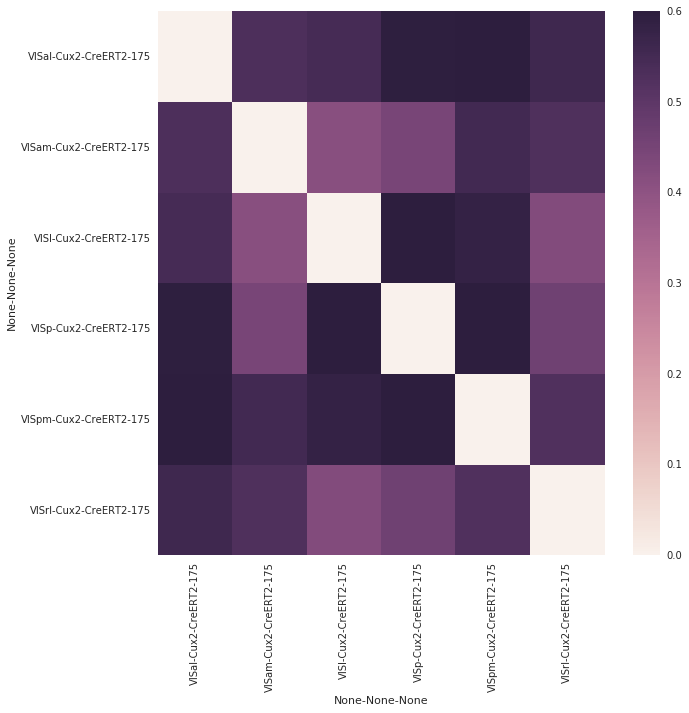

In [598]:
kt_all_diff = get_all_kt_matrix(one_area_diff_cres)
kt_all_diff= kt_all_diff.sort_index(axis=0).sort_index(axis=1)
plt.figure(figsize=(10,10))
ax=sns.heatmap(kt_all_diff,vmin=0,vmax=0.6)
fig=ax.get_figure()


In [ ]:
a

In [355]:
exps_grouped_cluster1=get_experiments_grouped(exps,targeted_structures,cre_lines,[175],
                                     rsm_name = 'rsa_mean_mean_mahala', cluster = None,
                                     rsm_selection='all')


nm115
nm117
nm119
nm121
nm123
nm125
nm127
nm129
nm131
nm133
nm135
nm137
nm139
nm141
nm143
nm145
nm147
nm149
nm148
nm146
nm140
nm144
nm41
nm43
nm45
nm47
nm49
nm51
nm53
nm55
nm57
nm59
nm61
nm63
nm65
nm67
nm69
nm71
nm73
nm75
nm77
nm79
nm81
nm83
nm85
nm87
nm89
nm91
nm93
nm95
nm97
nm99
nm101
nm103
nm105
nm107
nm109
nm111
nm113
nm116
nm120
nm124
nm128
nm132
nm136
nm142
nm134
nm118
nm126
nm138
nm122
(0.0, 0.0, 0.019999999552965164)
(0.0, 0.0, 0.07999999821186066)
(0.0, 0.0, 0.3199999928474426)
(0.0, 0.75, 0.019999999552965164)
(0.0, 0.75, 0.3199999928474426)
(30.0, 0.0, 0.07999999821186066)
(30.0, 0.0, 0.3199999928474426)
(30.0, 0.25, 0.3199999928474426)
(30.0, 0.5, 0.03999999910593033)
(60.0, 0.0, 0.019999999552965164)
(60.0, 0.0, 0.3199999928474426)
(60.0, 0.5, 0.019999999552965164)
(60.0, 0.75, 0.03999999910593033)
(60.0, 0.75, 0.1599999964237213)
(90.0, 0.0, 0.03999999910593033)
(90.0, 0.0, 0.3199999928474426)
(90.0, 0.5, 0.03999999910593033)
(90.0, 0.5, 0.3199999928474426)
(90.0, 0.75, 0

In [398]:
cre_lines=[u'Cux2-CreERT2',
 u'Emx1-IRES-Cre',
 u'Nr5a1-Cre',
 u'Rbp4-Cre_KL100',
 u'Rorb-IRES2-Cre']
imaging_depths=[175,275,350]
targeted_structures=boc.get_all_targeted_structures()
layers=['layer_2/3','layer_4','layer_5']
cre_lines

[u'Cux2-CreERT2',
 u'Emx1-IRES-Cre',
 u'Nr5a1-Cre',
 u'Rbp4-Cre_KL100',
 u'Rorb-IRES2-Cre']

In [599]:
exps_grouped_cluster2=get_experiments_grouped(exps[cluster1],'VISp',cre_lines,imaging_depths,
                                     rsm_name = 'rsa_mean_mean_mahala', cluster = None,
                                     rsm_selection='mean')


389
[175, 265, 275, 300, 320, 325, 335, 350, 365, 375, 435]
175
275
175
275
350
275
350
275


In [603]:
exps_grouped_cluster2=get_experiments_grouped(exps[cluster1],['VISp'],cre_lines,imaging_depths,
                                     rsm_name = 'rsa_mean_mean_mahala', cluster = None,
                                     rsm_selection='mean')


282
[175, 265, 275, 300, 320, 325, 335, 350, 365, 375, 435]
175
275
175
275
350
275
350
275


In [606]:
kt_all_cluster1

VISp                                    \
                        Cux2-CreERT2           Emx1-IRES-Cre             
                                 175       275           175       275   
VISp Cux2-CreERT2   175     0.000000  0.252733      0.247101  0.243817   
                    275     0.252733  0.000000      0.512321  0.464988   
     Emx1-IRES-Cre  175     0.247101  0.512321      0.000000  0.295925   
                    275     0.243817  0.464988      0.295925  0.000000   
                    350     0.126415  0.427533      0.398012  0.303990   
     Nr5a1-Cre      275     0.137791  0.480096      0.376824  0.325273   
     Rbp4-Cre_KL100 350     0.210794  0.453327      0.381720  0.359752   
     Rorb-IRES2-Cre 275     0.282085  0.628462      0.480943  0.435649   

                                                                           
                                  Nr5a1-Cre Rbp4-Cre_KL100 Rorb-IRES2-Cre  
                              350       275            350            275  
VISp Cux2-CreERT2   175  0.126415  0.137791       0.210794       0.282085  
                    275  0.427533  0.480096       0.453327       0.628462  
     Emx1-IRES-Cre  175  0.398012  0.376824       0.381720       0.480943  
                    275  0.303990  0.325273       0.359752       0.435649  
                    350  0.000000  0.512391       0.351231       0.460116  
     Nr5a1-Cre      275  0.512391  0.000000       0.406420       0.542618  
     Rbp4-Cre_KL100 350  0.351231  0.406420       0.000000       0.429732  
     Rorb-IRES2-Cre 275  0.460116  0.542618       0.429732       0.000000

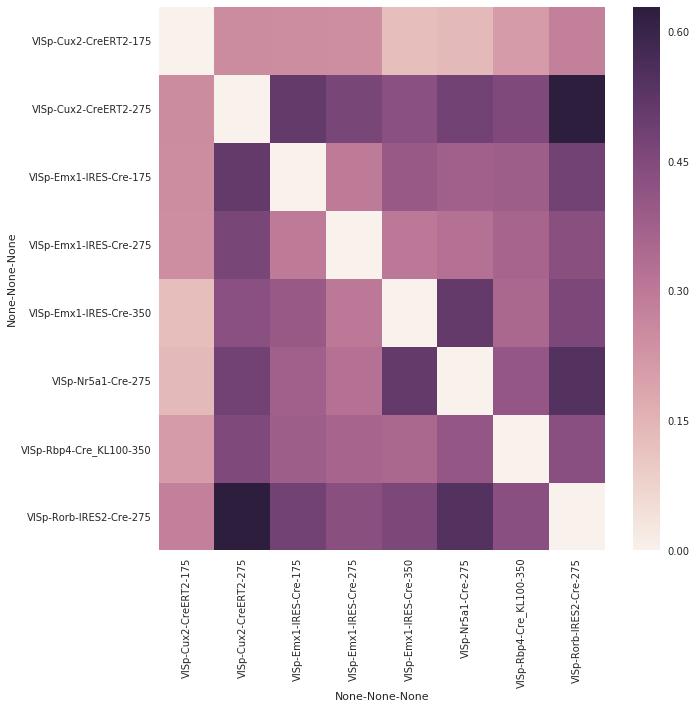

In [605]:
kt_all_cluster1 = get_all_kt_matrix(exps_grouped_cluster2)
kt_all_cluster1 = kt_all_cluster1.sort_index(axis=0).sort_index(axis=1)
plt.figure(figsize=(10,10))
sns.heatmap(kt_all_cluster1,vmin=0)


In [441]:
kt_all_cluster1.index=kt_all_cluster1.index.swaplevel(0,1)

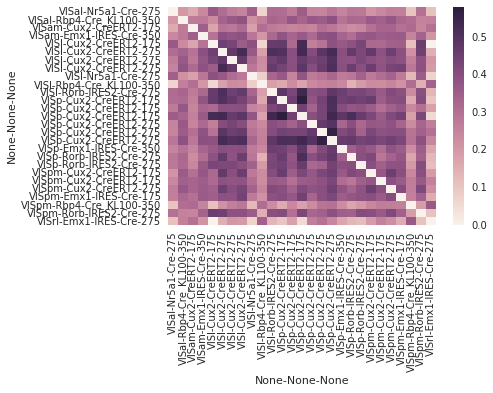

In [442]:
sns.heatmap(kt_all_cluster1,vmin=0)

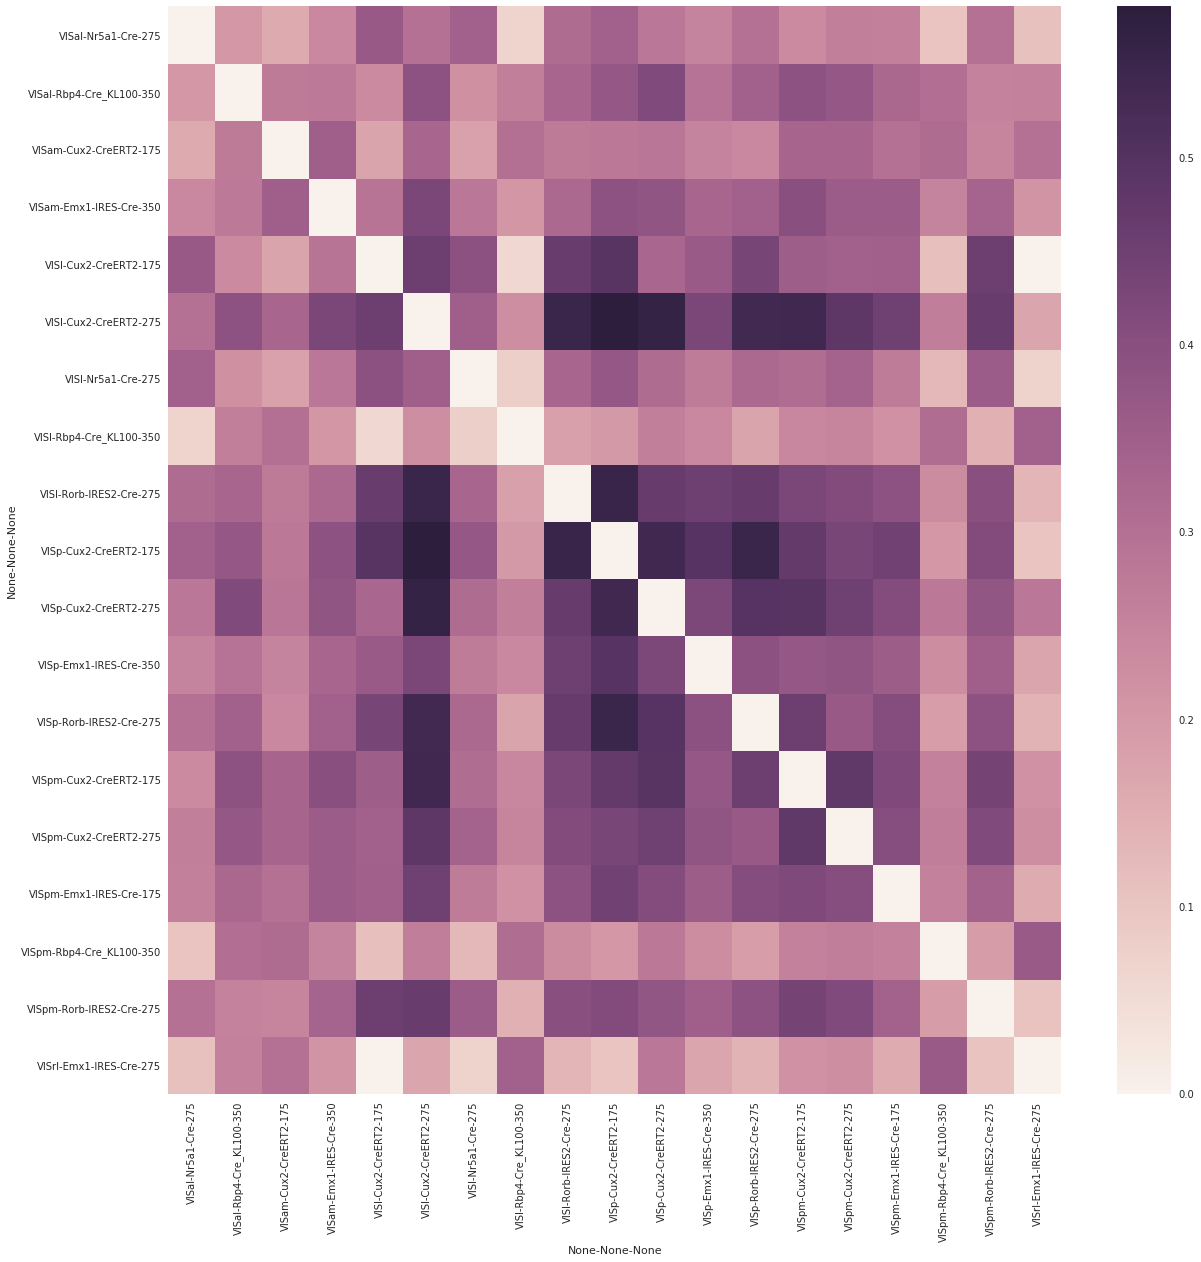

In [446]:
kt_all_cluster2 = get_all_kt_matrix(exps_grouped_cluster2)

kt_all_cluster2 = kt_all_cluster2.sort_index(axis=0).sort_index(axis=1)
plt.figure(figsize=(20,20))
sns.heatmap(kt_all_cluster2,vmin=0)


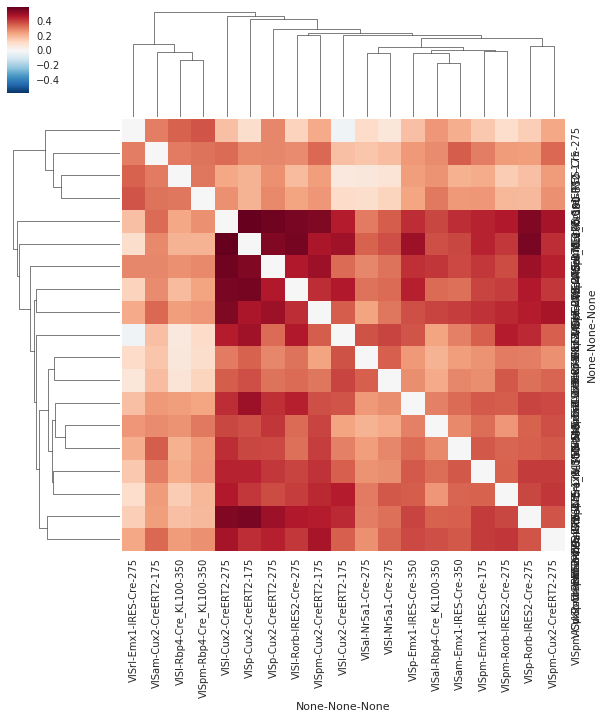

In [445]:
g = sns.clustermap(kt_all_cluster1)

In [328]:
exps_grouped_cluster1_layer=get_experiments_grouped_by_layer(exps,targeted_structures,layers,
                                                             rsm_name = 'rsa_mean_mean_mahala', cluster = None,
                                                             rsm_selection='all')


nm41
nm43
nm45
nm47
nm49
nm51
nm53
nm55
nm57
nm59
nm61
nm63
nm65
nm67
nm69
nm71
nm73
nm75
nm77
nm79
nm81
nm83
nm85
nm87
nm89
nm91
nm93
nm95
nm97
nm99
nm101
nm103
nm105
nm107
nm109
nm111
nm113
nm115
nm117
nm119
nm121
nm123
nm125
nm127
nm129
nm131
nm133
nm135
nm137
nm139
nm141
nm143
nm145
nm147
nm149
nm134
nm138
nm142
nm146
nm116
nm120
nm124
nm128
nm132
nm140
nm148
nm144
nm118
nm126
nm136
(0.0, 0.0, 0.019999999552965164)
(0.0, 0.0, 0.07999999821186066)
(0.0, 0.0, 0.3199999928474426)
(0.0, 0.75, 0.019999999552965164)
(0.0, 0.75, 0.3199999928474426)
(30.0, 0.0, 0.07999999821186066)
(30.0, 0.0, 0.3199999928474426)
(30.0, 0.25, 0.3199999928474426)
(30.0, 0.5, 0.03999999910593033)
(60.0, 0.0, 0.019999999552965164)
(60.0, 0.0, 0.3199999928474426)
(60.0, 0.5, 0.019999999552965164)
(60.0, 0.75, 0.03999999910593033)
(60.0, 0.75, 0.1599999964237213)
(90.0, 0.0, 0.03999999910593033)
(90.0, 0.0, 0.3199999928474426)
(90.0, 0.5, 0.03999999910593033)
(90.0, 0.5, 0.3199999928474426)
(90.0, 0.75, 0.07999

In [458]:
kt_all2 = get_all_kt_matrix(exps_grouped_cluster1_layer)
kt_all2 = kt_all2.sort_index(axis=0).sort_index(axis=1)
plt.figure(figsize=(40,40))
sns.heatmap(kt_all2,vmin=0)


ValueError: Unknown Distance Metric: targeted_structure

In [362]:
kt_all2 = kt_all2.sort_index(axis=0).sort_index(axis=1)

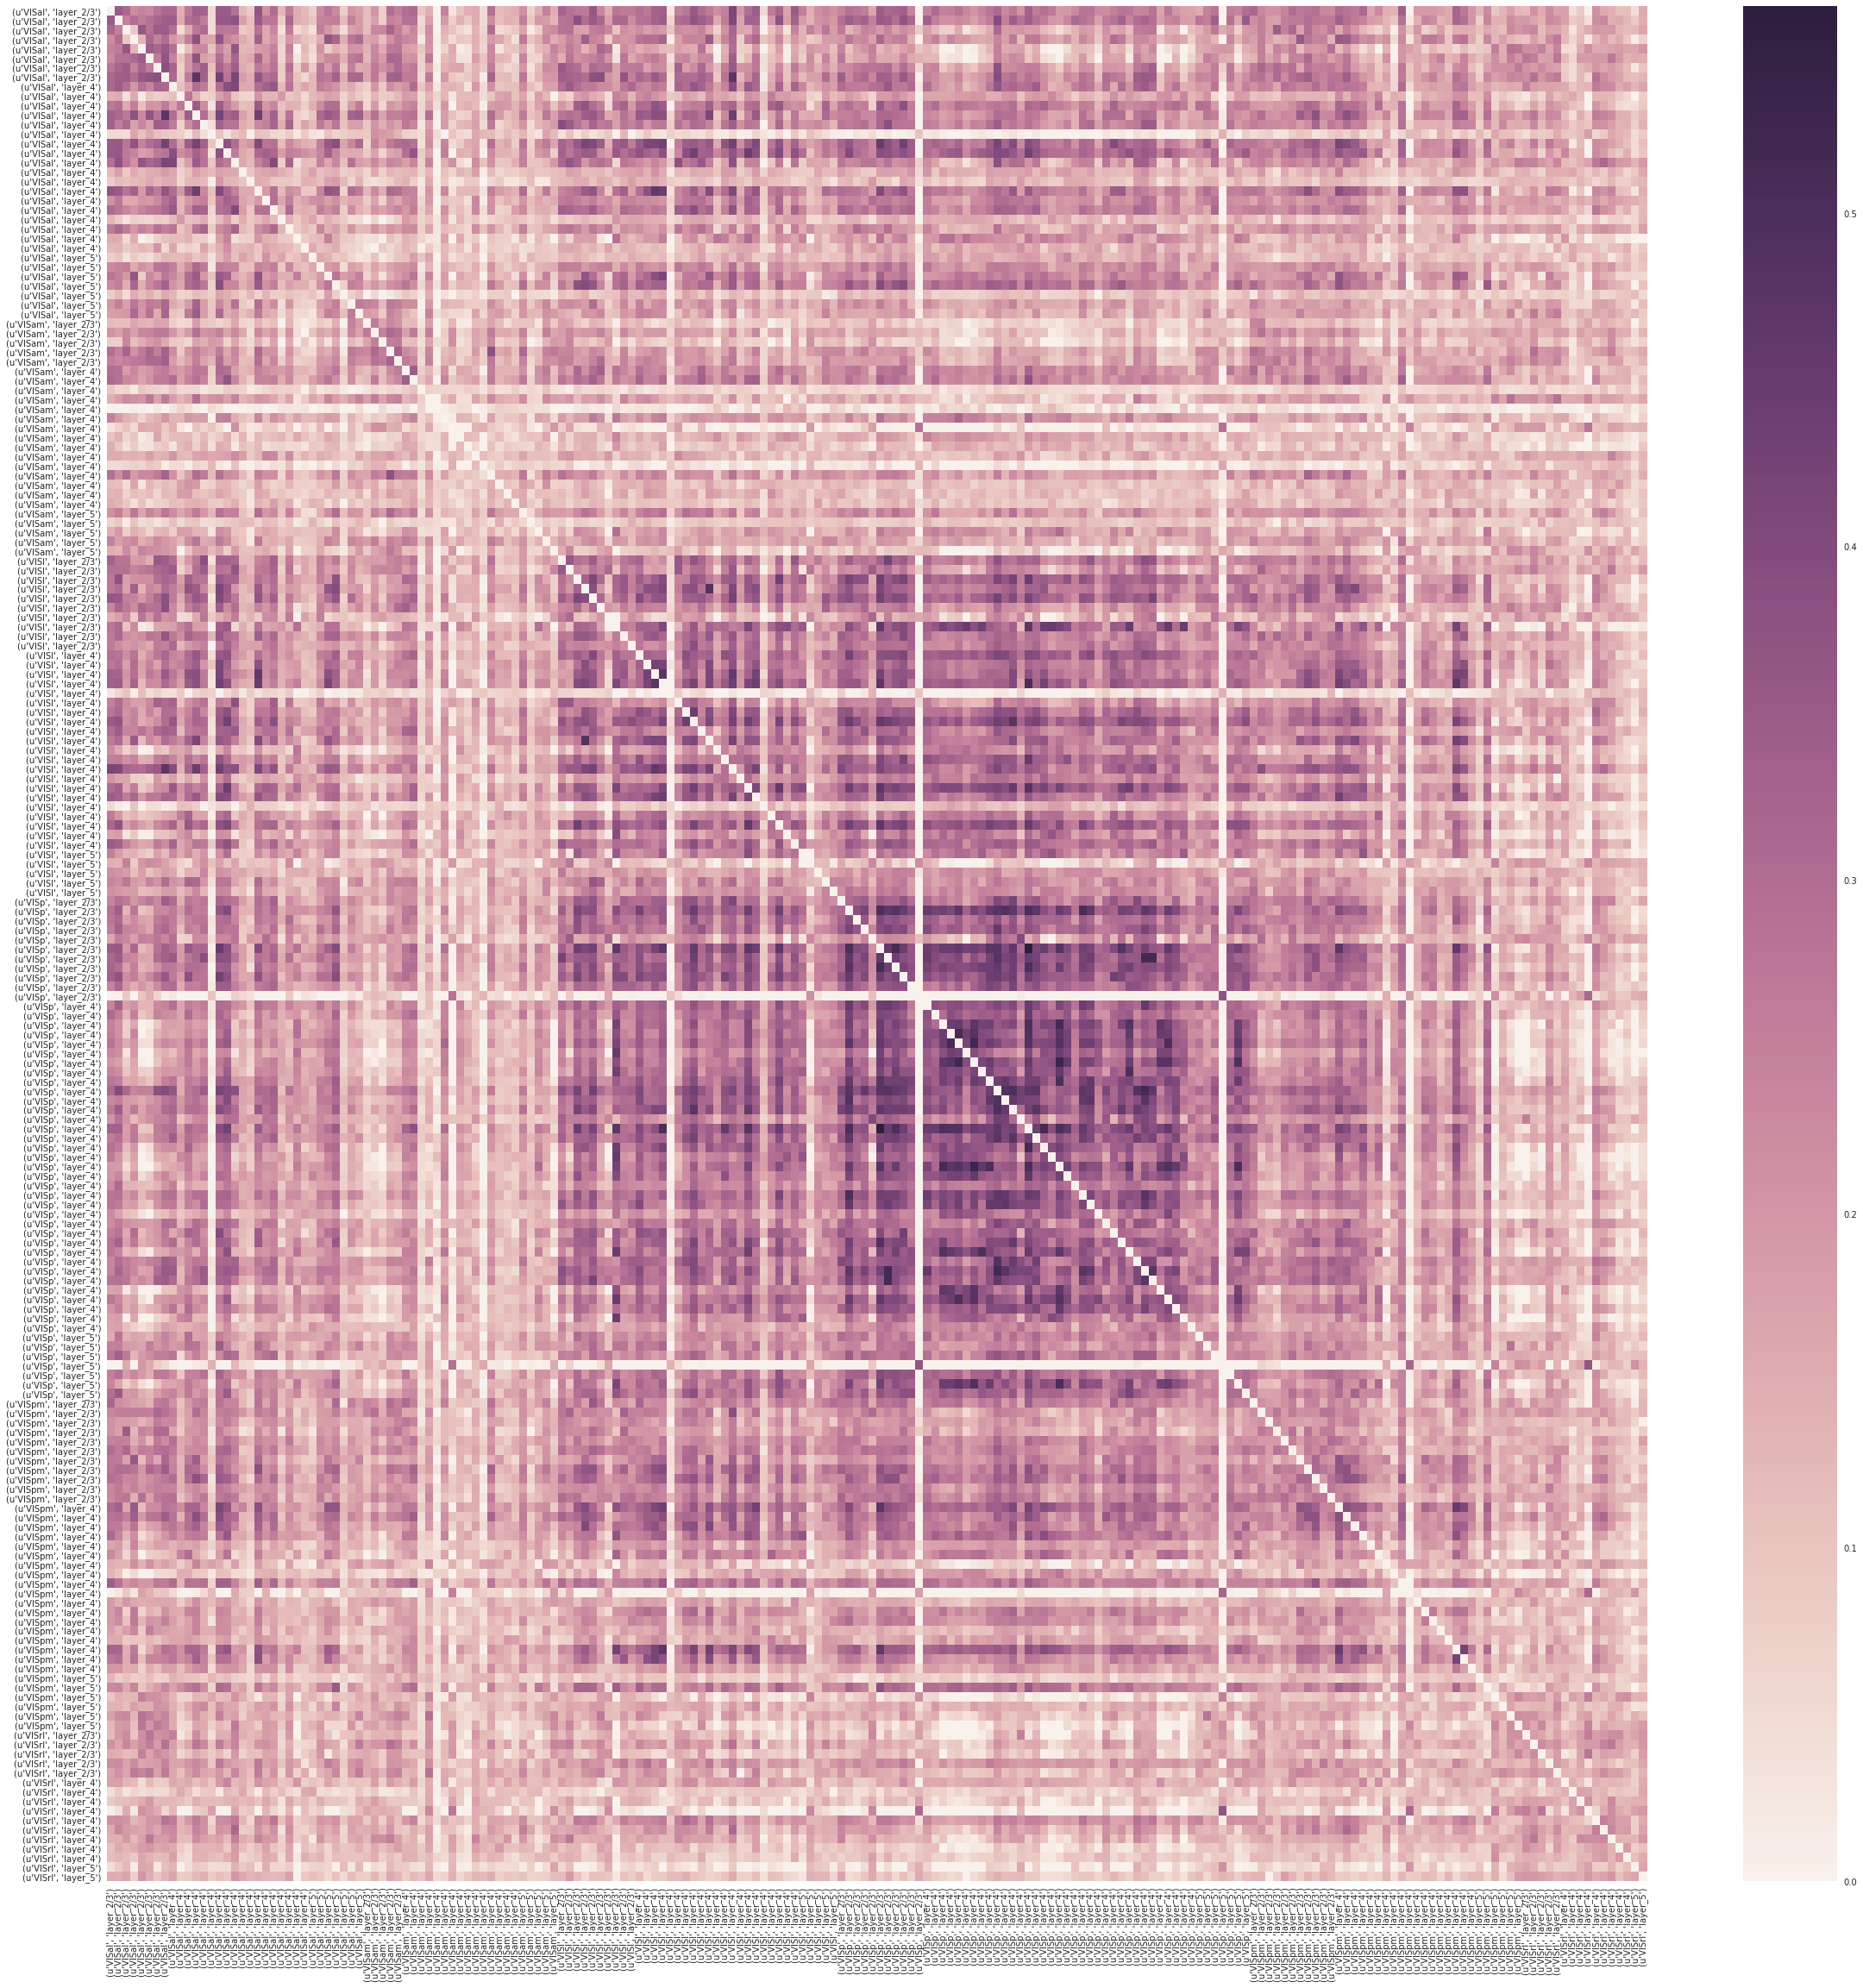

In [363]:
plt.figure(figsize=(40,40))
sns.heatmap(kt_all2,vmin=0)


In [ ]:
exps_grouped_cluster1_layer=get_experiments_grouped_by_layer(exps,targeted_structures,layers,
                                                             rsm_name = 'rsa_mean_mean_mahala', cluster = None,
                                                             rsm_selection='all')


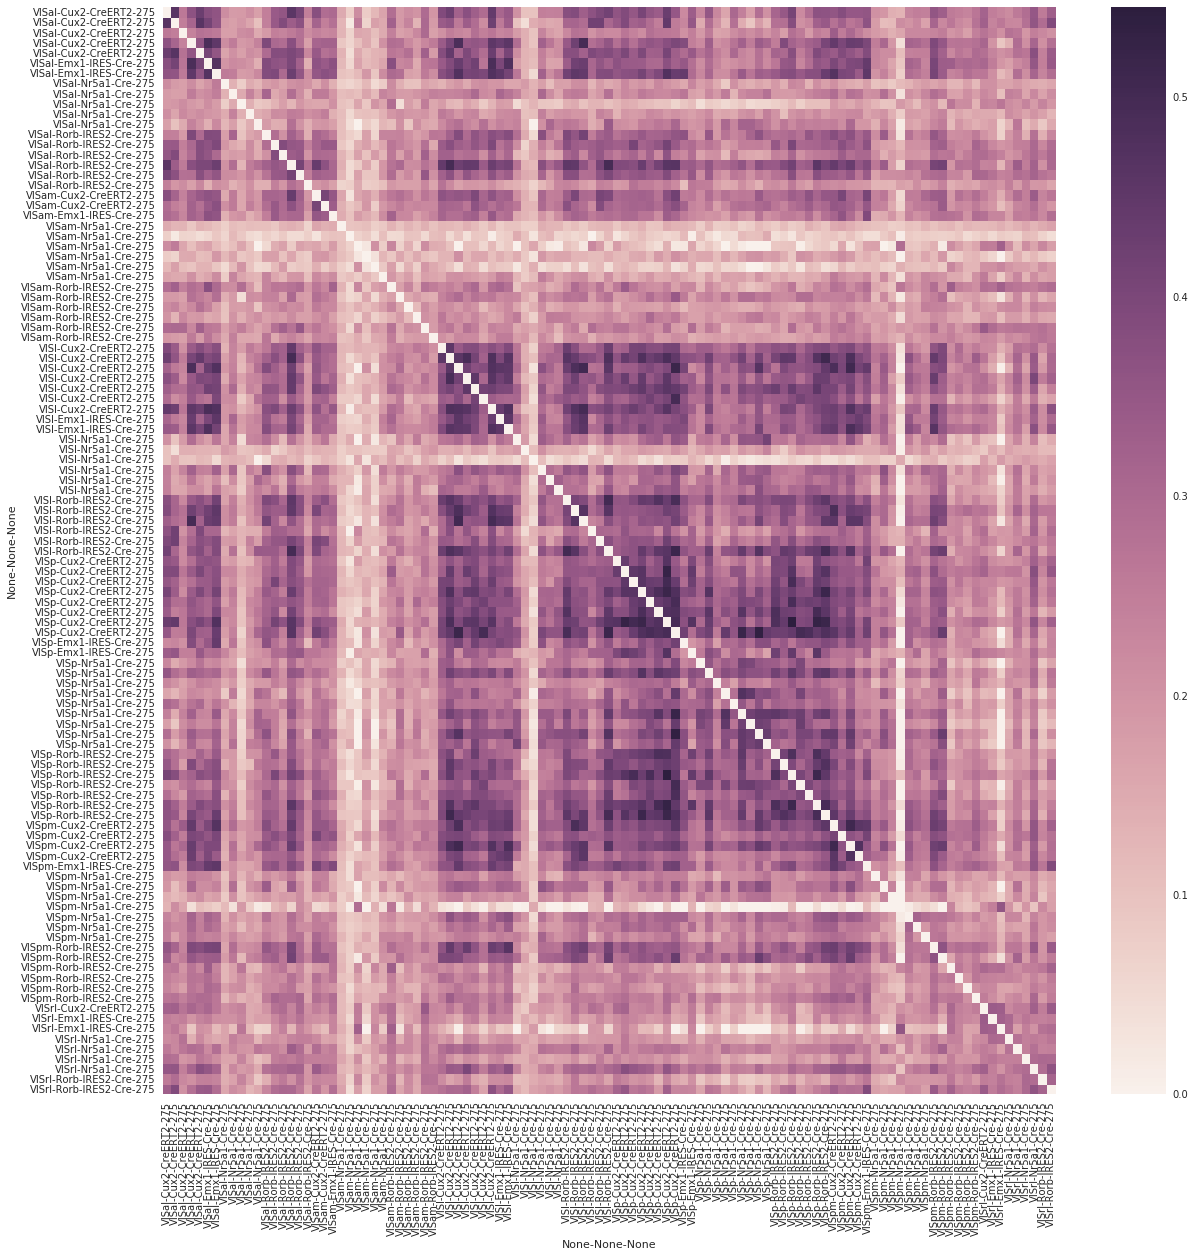

In [532]:
kt_all_cre = get_all_kt_matrix(exps_grouped_cluster1)
kt_all_cre = kt_all_cre.sort_index(axis=0).sort_index(axis=1)
plt.figure(figsize=(20,20))
ax = sns.heatmap(kt_all_cre,vmin=0)
#Returns the :class:~matplotlib.figure.Figure instance the artist belongs to
fig = ax.get_figure()
fig.savefig('Single_depth.pdf')

In [499]:
kt_all_cre.columns.get_level_values(0).isin(used_networks)

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True], dtype=bool)

In [536]:
exps_grouped_all_mean=get_experiments_grouped(exps,targeted_structures,cre_lines,imaging_depths,
                                                             rsm_name = 'rsa_mean_mean_mahala', cluster = None,
                                                             rsm_selection='mean')


230
[175, 265, 275, 300, 320, 325, 335, 350, 365, 375, 435]
175
275
175
275
350
275
350
275


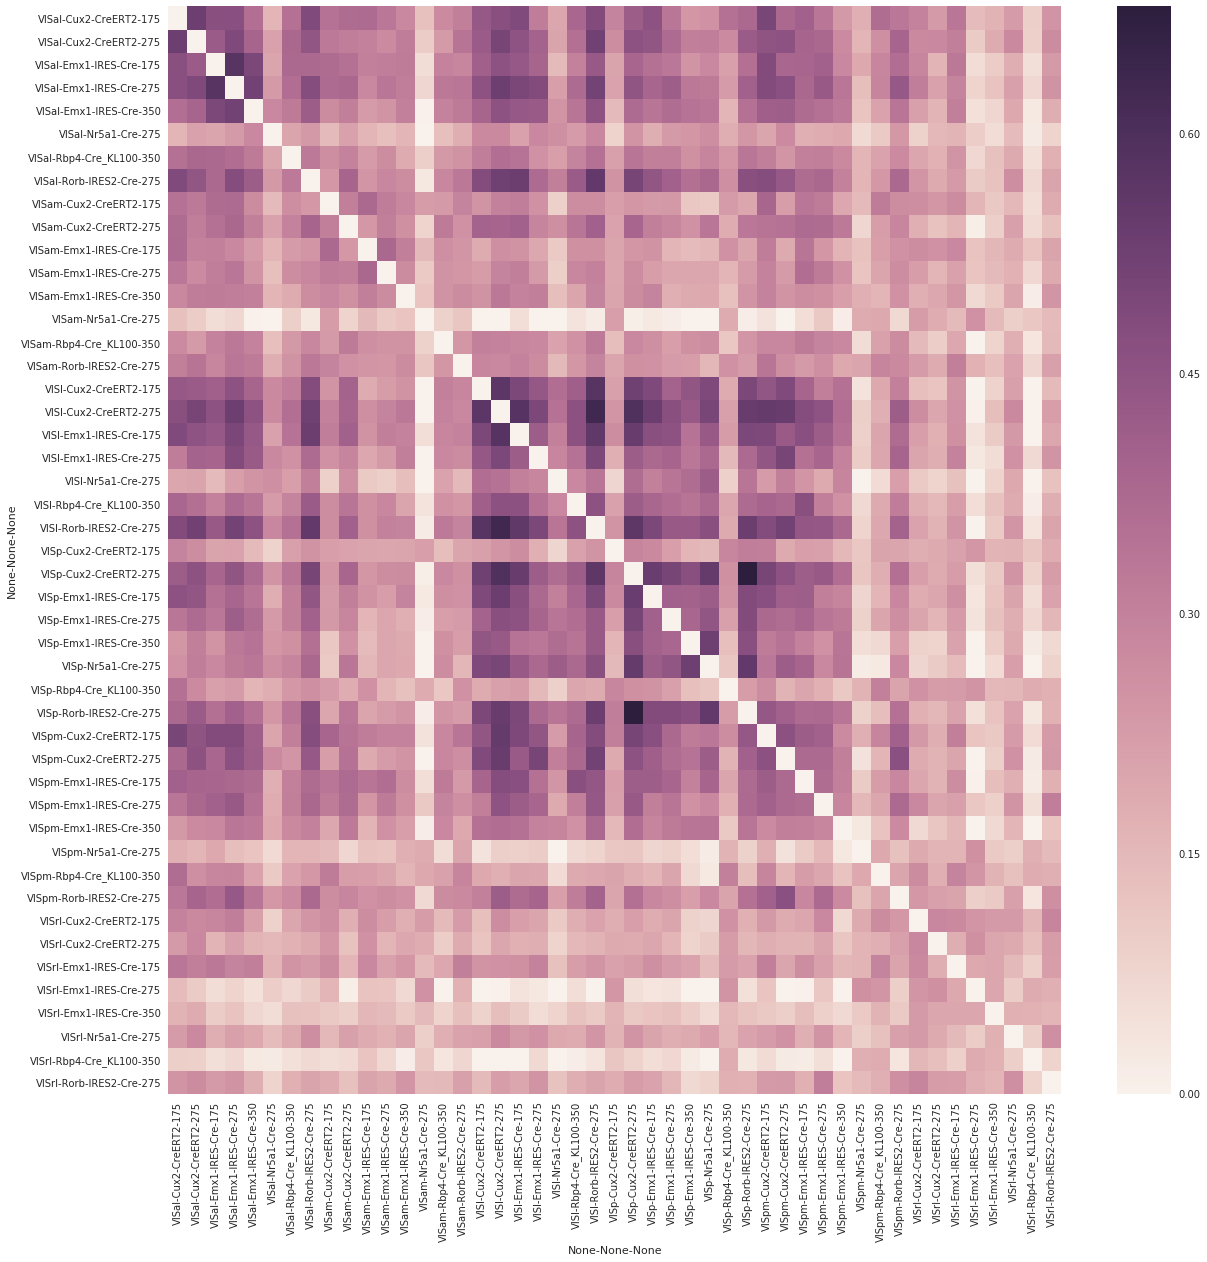

In [538]:
kt_all_cre_mean = get_all_kt_matrix(exps_grouped_all_mean)
kt_all_cre_mean = kt_all_cre_mean.sort_index(axis=0).sort_index(axis=1)
plt.figure(figsize=(20,20))
ax = sns.heatmap(kt_all_cre_mean,vmin=0)
#Returns the :class:~matplotlib.figure.Figure instance the artist belongs to
fig = ax.get_figure()
fig.savefig('Single_depth_mean.pdf')

In [522]:
network_colors

VISal    [0.447242064224, 0.649103128728, 0.629474696762]
VISal    [0.447242064224, 0.649103128728, 0.629474696762]
VISal    [0.447242064224, 0.649103128728, 0.629474696762]
VISal    [0.447242064224, 0.649103128728, 0.629474696762]
VISal    [0.447242064224, 0.649103128728, 0.629474696762]
VISal    [0.447242064224, 0.649103128728, 0.629474696762]
VISal    [0.447242064224, 0.649103128728, 0.629474696762]
VISal    [0.447242064224, 0.649103128728, 0.629474696762]
VISal    [0.447242064224, 0.649103128728, 0.629474696762]
VISal    [0.447242064224, 0.649103128728, 0.629474696762]
VISal    [0.447242064224, 0.649103128728, 0.629474696762]
VISal    [0.447242064224, 0.649103128728, 0.629474696762]
VISal    [0.447242064224, 0.649103128728, 0.629474696762]
VISal    [0.447242064224, 0.649103128728, 0.629474696762]
VISal    [0.447242064224, 0.649103128728, 0.629474696762]
VISal    [0.447242064224, 0.649103128728, 0.629474696762]
VISal    [0.447242064224, 0.649103128728, 0.629474696762]
VISal    [0.44

In [452]:
cre_lines=[u'Cux2-CreERT2',
 u'Emx1-IRES-Cre',
 u'Nr5a1-Cre',
 u'Rbp4-Cre_KL100',
 u'Rorb-IRES2-Cre']
imaging_depths=boc.get_all_imaging_depths()
targeted_structures=boc.get_all_targeted_structures()
layers=['layer_2/3','layer_4','layer_5']
cre_lines

[u'Cux2-CreERT2',
 u'Emx1-IRES-Cre',
 u'Nr5a1-Cre',
 u'Rbp4-Cre_KL100',
 u'Rorb-IRES2-Cre']

In [466]:
exps_grouped_layer=get_experiments_grouped(exps,['VISp','VISl'],cre_lines, imaging_depths,
                                         rsm_name = 'rsa_mean_mean_mahala', cluster = None,
                                         rsm_selection='mean')


245
[175, 265, 275, 300, 320, 325, 335, 350, 365, 375, 435]
175
275
175
275
350
275
350
275


In [467]:
exps_grouped_layer.shape

(15, 4)

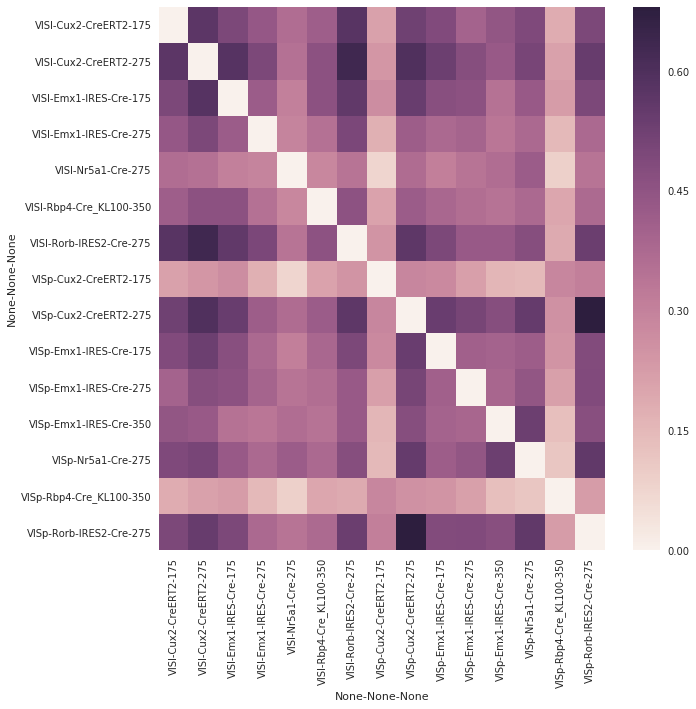

In [469]:
kt_all_layer_mean = get_all_kt_matrix(exps_grouped_layer)
kt_all_layer_mean = kt_all_layer_mean.sort_index(axis=0).sort_index(axis=1)
plt.figure(figsize=(10,10))
sns.heatmap(kt_all_layer_mean ,vmin=0)



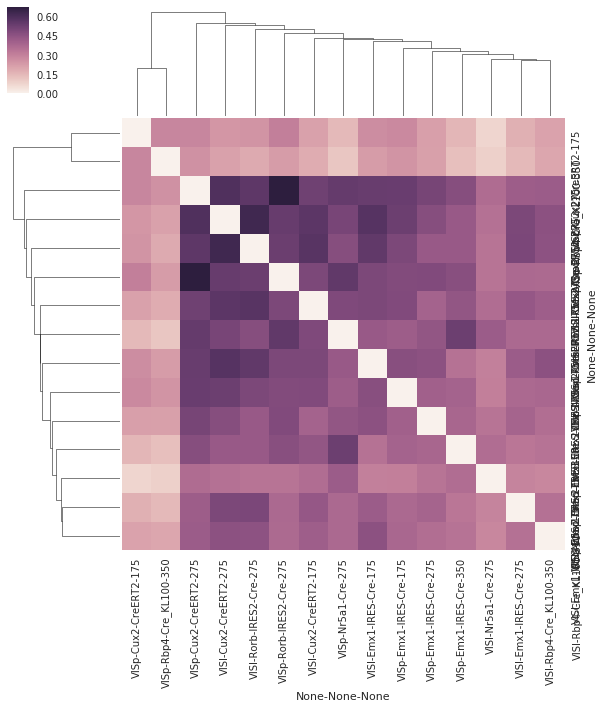

In [470]:
sns.clustermap(kt_all_layer_mean)

In [165]:
exps_grouped_mean=get_experiments_grouped(exps,targeted_structures,cre_lines,imaging_depths,
                                     rsm_name = 'rsa_mean_mean_mahala', cluster = None,
                                     rsm_selection='mean')


nm115
nm117
nm119
nm121
nm123
nm125
nm127
nm129
nm131
nm133
nm135
nm137
nm139
nm141
nm143
nm145
nm147
nm149
nm148
nm146
nm140
nm144
nm41
nm43
nm45
nm47
nm49
nm51
nm53
nm55
nm57
nm59
nm61
nm63
nm65
nm67
nm69
nm71
nm73
nm75
nm77
nm79
nm81
nm83
nm85
nm87
nm89
nm91
nm93
nm95
nm97
nm99
nm101
nm103
nm105
nm107
nm109
nm111
nm113
nm116
nm120
nm124
nm128
nm132
nm136
nm142
nm134
nm118
nm126
nm138
nm122
(0.0, 0.0, 0.019999999552965164)
(0.0, 0.0, 0.07999999821186066)
(0.0, 0.0, 0.3199999928474426)
(0.0, 0.75, 0.019999999552965164)
(0.0, 0.75, 0.3199999928474426)
(30.0, 0.0, 0.07999999821186066)
(30.0, 0.0, 0.3199999928474426)
(30.0, 0.25, 0.3199999928474426)
(30.0, 0.5, 0.03999999910593033)
(60.0, 0.0, 0.019999999552965164)
(60.0, 0.0, 0.3199999928474426)
(60.0, 0.5, 0.019999999552965164)
(60.0, 0.75, 0.03999999910593033)
(60.0, 0.75, 0.1599999964237213)
(90.0, 0.0, 0.03999999910593033)
(90.0, 0.0, 0.3199999928474426)
(90.0, 0.5, 0.03999999910593033)
(90.0, 0.5, 0.3199999928474426)
(90.0, 0.75, 0

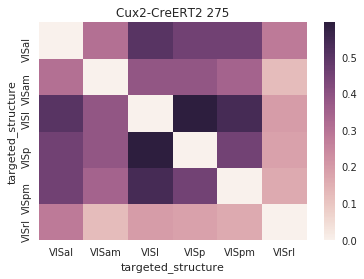

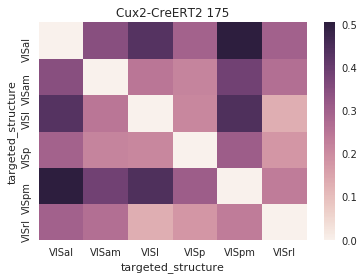

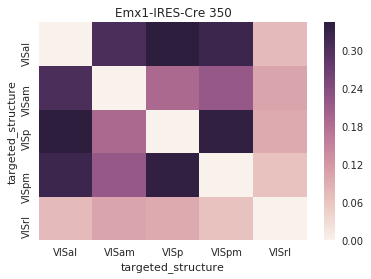

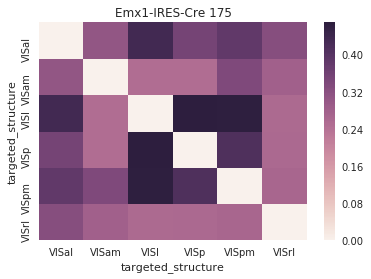

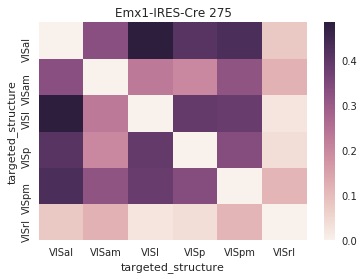

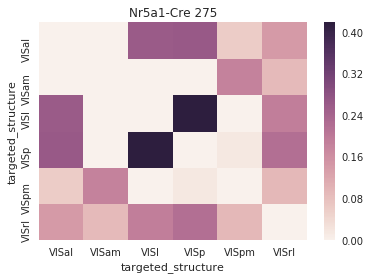

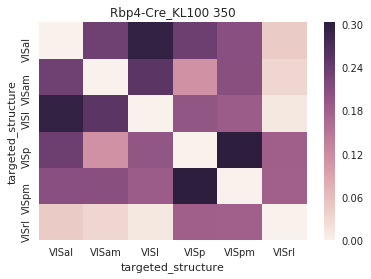

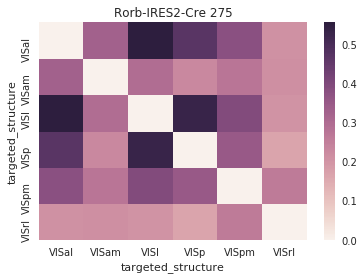

In [166]:
kt_df = get_kt_matrix(exps_grouped_mean,'targeted_structure')


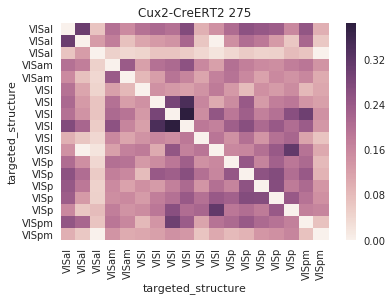

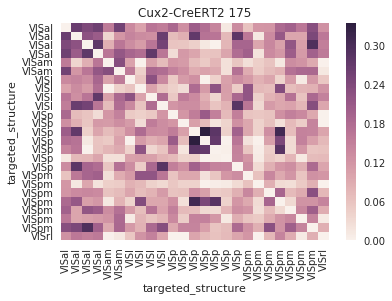

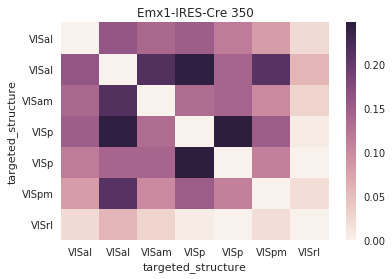

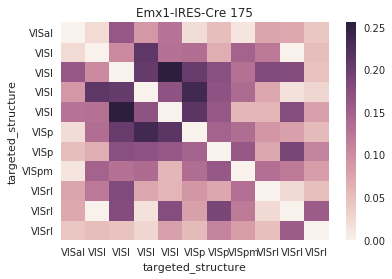

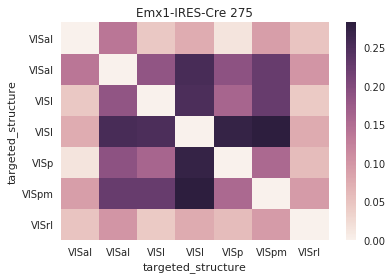

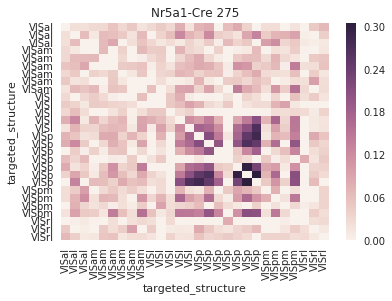

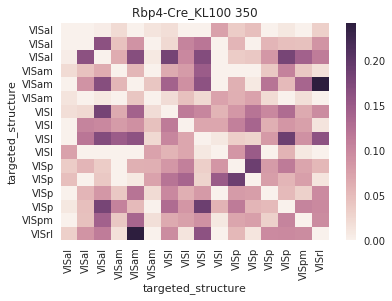

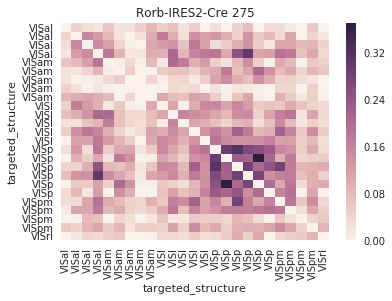

In [224]:
kt_dfs=get_kt_matrix(just_nonzeros,'targeted_structure')

In [72]:
exps.head()

,cre_line,donor_name,failed,id,imaging_depth,reporter_line,specimen_name,tags,targeted_structure,rsa_mean_mean_mahala,rsa_random_mean_mahala,rsa_mean_mean_spectral_embedding,rsa_mean_mean_PCA,valid_stim
0,Cux2-CreERT2,283284,False,566759225,275,Ai93(TITL-GCaMP6f),Cux2-CreERT2;Camk2a-tTA;Ai93-283284,[],VISam,"(0.0, 0.0,...","(0.0, 0.0,...",0,0,"Index([ u'(0.0, 0.0, 0.019999999552965164)', ..."
1,Nr5a1-Cre,261969,False,546328009,275,Ai93(TITL-GCaMP6f),Nr5a1-Cre;Camk2a-tTA;Ai93-261969,[],VISal,"(0.0, 0.0,...","(0.0, 0.0,...",0,0,"Index([ u'(0.0, 0.0, 0.019999999552965164)', ..."
2,Scnn1a-Tg3-Cre,230570,False,511510911,350,Ai93(TITL-GCaMP6f),Scnn1a-Tg3-Cre;Camk2a-tTA;Ai93-230570,[],VISp,"(0.0, 0.0,...","(0.0, 0.0,...",0,0,"Index([ u'(0.0, 0.0, 0.019999999552965164)', ..."
3,Emx1-IRES-Cre,284669,False,569792815,350,Ai93(TITL-GCaMP6f),Emx1-IRES-Cre;Camk2a-tTA;Ai93-284669,[],VISam,"(0.0, 0.0,...","(0.0, 0.0,...",0,0,"Index([ u'(0.0, 0.0, 0.019999999552965164)', ..."
4,Rbp4-Cre_KL100,234584,False,511511015,350,Ai93(TITL-GCaMP6f),Rbp4-Cre;Camk2a-tTA;Ai93-234584,[],VISpm,"(0.0, 0.0,...","(0.0, 0.0,...",0,0,"Index([ u'(0.0, 0.0, 0.019999999552965164)', ..."


In [78]:
expt_container_id=566759225
expt_session_info = boc.get_ophys_experiments(experiment_container_ids=[expt_container_id])
ns_exps=boc.get_ophys_experiments(experiment_container_ids=[expt_container_id],stimuli=['natural_scenes'])

session_id=ns_exps[0]['id']
data_set = boc.get_ophys_experiment_data(ophys_experiment_id=session_id)
def get_natural_scenes(boc, session_id):
    
    # Load the experimental data
    data_set = boc.get_ophys_experiment_data(session_id)

    # Read in the array of images
    scenes = data_set.get_stimulus_template('natural_scenes')

    return scenes

In [79]:
scenes=get_natural_scenes(boc,session_id)

In [110]:
rsm=exps.iloc[0].rsa_mean_mean_mahala

In [131]:
def get_rsm_ns(rsm):
    ind_list=[]
    for i in rsm.index:
        if type(i)==float and i>-1:
            ind_list.append(i)
    rsm=rsm.loc[ind_list,ind_list]
    return rsm


In [135]:
exps2=exps.rsa_mean_mean_mahala.apply(get_rsm_ns)

AttributeError: 'int' object has no attribute 'index'

In [136]:
exps

,cre_line,donor_name,failed,id,imaging_depth,reporter_line,specimen_name,tags,targeted_structure,rsa_mean_mean_mahala,rsa_random_mean_mahala,rsa_mean_mean_spectral_embedding,rsa_mean_mean_PCA,valid_stim
0,Cux2-CreERT2,283284,False,566759225,275,Ai93(TITL-GCaMP6f),Cux2-CreERT2;Camk2a-tTA;Ai93-283284,[],VISam,"(0.0, 0.0,...","(0.0, 0.0,...",0,0,"Index([ u'(0.0, 0.0, 0.019999999552965164)', ..."
1,Nr5a1-Cre,261969,False,546328009,275,Ai93(TITL-GCaMP6f),Nr5a1-Cre;Camk2a-tTA;Ai93-261969,[],VISal,"(0.0, 0.0,...","(0.0, 0.0,...",0,0,"Index([ u'(0.0, 0.0, 0.019999999552965164)', ..."
2,Scnn1a-Tg3-Cre,230570,False,511510911,350,Ai93(TITL-GCaMP6f),Scnn1a-Tg3-Cre;Camk2a-tTA;Ai93-230570,[],VISp,"(0.0, 0.0,...","(0.0, 0.0,...",0,0,"Index([ u'(0.0, 0.0, 0.019999999552965164)', ..."
3,Emx1-IRES-Cre,284669,False,569792815,350,Ai93(TITL-GCaMP6f),Emx1-IRES-Cre;Camk2a-tTA;Ai93-284669,[],VISam,"(0.0, 0.0,...","(0.0, 0.0,...",0,0,"Index([ u'(0.0, 0.0, 0.019999999552965164)', ..."
4,Rbp4-Cre_KL100,234584,False,511511015,350,Ai93(TITL-GCaMP6f),Rbp4-Cre;Camk2a-tTA;Ai93-234584,[],VISpm,"(0.0, 0.0,...","(0.0, 0.0,...",0,0,"Index([ u'(0.0, 0.0, 0.019999999552965164)', ..."
5,Rorb-IRES2-Cre,249122,False,530739574,275,Ai93(TITL-GCaMP6f),Rorb-IRES2-Cre;Camk2a-tTA;Ai93-249122,[],VISp,"(0.0, 0.0,...","(0.0, 0.0,...",0,0,"Index([ u'(0.0, 0.0, 0.019999999552965164)', ..."
6,Cux2-CreERT2,222426,False,511510736,175,Ai93(TITL-GCaMP6f),Cux2-CreERT2;Camk2a-tTA;Ai93-222426,[],VISp,"(0.0, 0.0,...","(0.0, 0.0,...",0,0,"Index([ u'(0.0, 0.0, 0.019999999552965164)', ..."
7,Rorb-IRES2-Cre,222181,False,511510733,275,Ai93(TITL-GCaMP6f),Rorb-IRES2-Cre;Camk2a-tTA;Ai93-222181,[],VISpm,"(0.0, 0.0,...","(0.0, 0.0,...",0,0,"Index([ u'(0.0, 0.0, 0.019999999552965164)', ..."
8,Cux2-CreERT2,225036,False,511510797,175,Ai93(TITL-GCaMP6f),Cux2-CreERT2;Camk2a-tTA;Ai93-225036,[],VISal,"(0.0, 0.0,...","(0.0, 0.0,...",0,0,"Index([ u'(0.0, 0.0, 0.019999999552965164)', ..."
9,Rorb-IRES2-Cre,228786,False,511511001,275,Ai93(TITL-GCaMP6f),Rorb-IRES2-Cre;Camk2a-tTA;Ai93-228786,[],VISpm,"(0.0, 0.0,...","(0.0, 0.0,...",0,0,"Index([ u'(0.0, 0.0, 0.019999999552965164)', ..."


In [133]:
rsm

,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,...,108.0,109.0,110.0,111.0,112.0,113.0,114.0,115.0,116.0,117.0
0.0,0.000000,10.868924,12.913942,12.072546,7.269692,8.765530,12.053245,9.074401,8.744029,14.534979,...,13.903362,8.882002,9.079991,12.949290,11.420471,13.709447,13.092994,16.518308,8.215101,8.969641
1.0,10.868924,0.000000,9.105454,11.719366,8.666270,8.707925,11.252736,8.651541,10.293655,9.564884,...,14.341173,7.253528,8.899664,14.196133,11.905349,18.313993,11.806425,15.540283,8.601003,8.369676
2.0,12.913942,9.105454,0.000000,7.640002,10.724188,9.080139,10.699558,10.876736,10.323056,10.974281,...,16.698693,8.753533,10.946662,14.429932,11.613321,18.757729,14.477073,17.792401,9.483360,10.229898
3.0,12.072546,11.719366,7.640002,0.000000,9.728153,9.138572,14.833230,13.302676,10.972632,15.653122,...,15.529140,10.466736,11.033612,13.168006,12.491298,17.882862,15.999114,16.669067,12.435021,11.137933
4.0,7.269692,8.666270,10.724188,9.728153,0.000000,6.467906,10.756761,8.392884,9.171660,12.445727,...,11.319235,7.237516,7.274110,9.195787,9.397355,16.220441,14.557436,17.179029,6.522485,7.110418
5.0,8.765530,8.707925,9.080139,9.138572,6.467906,0.000000,9.368435,7.320229,6.031252,10.816247,...,12.099355,6.550134,7.099284,9.758949,8.826137,16.406687,12.528468,14.631997,7.308595,6.242196
6.0,12.053245,11.252736,10.699558,14.833230,10.756761,9.368435,0.000000,9.491488,10.191525,10.731026,...,12.608518,10.762220,11.557009,15.597961,12.153621,18.504756,14.215235,20.556261,10.724613,10.719551
7.0,9.074401,8.651541,10.876736,13.302676,8.392884,7.320229,9.491488,0.000000,6.232921,8.330101,...,12.260819,7.404109,5.865840,13.067530,7.637447,17.569104,11.202742,14.764997,7.196787,7.866979
8.0,8.744029,10.293655,10.323056,10.972632,9.171660,6.031252,10.191525,6.232921,0.000000,9.717376,...,12.148541,8.725756,6.992888,11.796186,8.790966,17.632913,12.306421,12.492955,8.764085,8.033562
9.0,14.534979,9.564884,10.974281,15.653122,12.445727,10.816247,10.731026,8.330101,9.717376,0.000000,...,14.769889,11.434292,11.151279,17.762991,9.379832,20.970340,15.314609,17.867833,10.210039,10.102403


In [215]:
from sklearn.manifold import Isomap, LocallyLinearEmbedding, SpectralEmbedding, TSNE, MDS
from sklearn.decomposition import PCA

In [ ]:
# to do: modify get_experiments_grouped so that it takes into account the valid_stimuli columns

Or let's try to visualize the kts with MDS

In [289]:
kt_df = kt_dfs[-1]
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=6)
results = mds.fit(0.6-kt_df.values)
to_plot = results.embedding_

NameError: name 'kt_dfs' is not defined

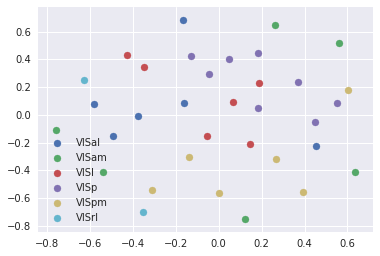

In [440]:

plt.subplots_adjust(bottom = 0.1)
plt.subplots_adjust(bottom = 0.1)

areas = kt_df.columns

for area in areas.unique():

    plt.scatter(
        to_plot[areas==area, 0], to_plot[areas==area, 1], marker = 'o'
        )

plt.legend(areas.unique())

In [290]:

mds = MDS(n_components=2, dissimilarity="precomputed", random_state=6)
results = mds.fit(0.6-kt_all2.values)
to_plot = results.embedding_

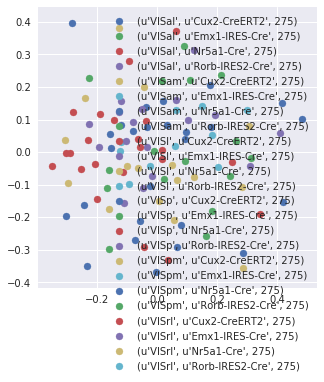

In [291]:
plt.figure(figsize=(5,5))
plt.subplots_adjust(bottom = 0.1)
plt.subplots_adjust(bottom = 0.1)

areas = kt_all2.columns

for area in areas.unique():

    plt.scatter(
        to_plot[areas==area, 0], to_plot[areas==area, 1], marker = 'o'
        )

plt.legend(areas.unique())

In [446]:
to_plot

,cre_line,imaging_depth,targeted_structure,rsm
0,Cux2-CreERT2,275,VISal,"[[0.0, 14.0271879134, 17.7364615024, 17.471313..."
1,Cux2-CreERT2,275,VISal,"[[0.0, 19.7863268783, 24.5694978749, 20.453725..."
2,Cux2-CreERT2,275,VISal,"[[0.0, 10.065717023, 10.2442107709, 10.3606364..."
3,Cux2-CreERT2,275,VISal,"[[0.0, 19.5142452541, 20.1135017267, 20.266742..."
4,Cux2-CreERT2,275,VISal,"[[0.0, 12.7419734687, 12.0693315323, 11.451070..."


In [ ]:
exps_grouped['targeted_structure'].unique()

In [ ]:
available_targeted_structures=exps[(exps.cre_line==cre_line) & (exps.imaging_depth==imaging_depth)].targeted_structure.unique()
available_targeted_structures

In [ ]:
for cre_line in cre_lines
sns.heatmap(kt_df)
plt.title(cre_lines+imaging_depths)

In [ ]:
np.fill_diagonal(kt_matrix,0)
sns.heatmap(kt_matrix)

In [ ]:
rsm=exps.groupby(['cre_line','imaging_depth','targeted_structure']).get_group((cre_line,imaging_depth,targeted_structure)).rsm.mean()

In [ ]:
to_add=pd.DataFrame(data=[cre_line,imaging_depth,targeted_structure,rsm],index=['cre_line','imaging_depth','targeted_structure','rsm'])

In [ ]:
exps_grouped=exps_grouped.append(to_add.T)

In [ ]:
exps_grouped.head()